In [20]:
using BenchmarkTools, LinearAlgebra, BandedMatrices, Polynomials, PyPlot
include("backsub.jl")
include("invBiU.jl")

BLAS.get_num_threads()

# BLAS.set_num_threads(8)
# BLAS.get_num_threads()


8

In [6]:
n = 10
U = big.(triu(rand(n, n))) + 10*I
b = big.(rand(n))
x = BackSubVec(U, b)

10-element Vector{BigFloat}:
  0.04975482036625469386791271917512527940592810306964456235379593439690031680446959
  0.05885875805342585645348994705376207000908544099746511536291537037980808816925533
  0.01482333145945638876582021374645552683215446868996321821523079456953257949179873
 -0.007194036609893053686316711708626208815464523791635028907454036478123220413009875
  0.02979457799205594189358256108707719226305196146464712552685228762872138879972167
  0.04793625341258271269445950446166030811070913434504115492959700883345673742482976
  0.06419099335409957661746635569504753551810757193537930224624771215435280890492216
  0.04896534176373223558075992701602541139422946299258828205059447634109304730712886
  0.06170516235450979061065387848808543621366604550115947691013546016034711685770223
  0.07835355284605693477950045357432801122902118128935868793719711634135334189405174

In [9]:
@benchmark BackSubVec(U, b);
@btime BackSubVec(U, b);

  4.691 μs (203 allocations: 11.17 KiB)


BandedMatrix{BigFloat, Matrix{BigFloat}, Base.OneTo{Int64}}
BandedMatrix{BigFloat, Matrix{BigFloat}, Base.OneTo{Int64}}
1.556907427447138542724457297848740307500476012730015553345490620945829611241884e-77
BandedMatrix{BigFloat, Matrix{BigFloat}, Base.OneTo{Int64}}
2.590850566528333387615905558840119871334800109330884415507111041050577540948728e-77
BandedMatrix{BigFloat, Matrix{BigFloat}, Base.OneTo{Int64}}
4.934013608912441698260722313222335168344819016480632521349717932528944619412962e-77
BandedMatrix{BigFloat, Matrix{BigFloat}, Base.OneTo{Int64}}
8.670048234876189416969638066112069057022725589861824698237717106992587236754549e-77
BandedMatrix{BigFloat, Matrix{BigFloat}, Base.OneTo{Int64}}
1.286375215577994326089697185513748913185389702162264054548548071075563586070338e-76
BandedMatrix{BigFloat, Matrix{BigFloat}, Base.OneTo{Int64}}
1.756770781393826432283304863101478373572714771416522274551002754146459061173282e-76
BandedMatrix{BigFloat, Matrix{BigFloat}, Base.OneTo{Int64}}
BandedMatr

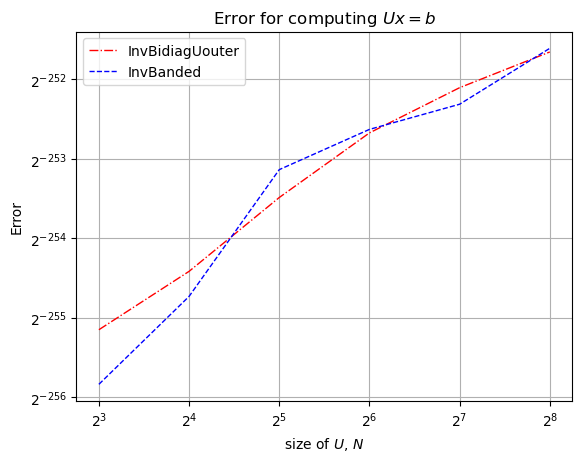

In [194]:

function getU(n, bᵤ, Utype="mat", elmtype="float")
    if Utype == "banded"
        if elmtype == "bigfloat"
            U = big.(BandedMatrix(rand(n, n), (0, bᵤ))) + 100*I
        else
            U = BandedMatrix(rand(n, n), (0, bᵤ)) + 100*I
        end
        println(typeof(U))
        return U
    end

    if elmtype == "bigfloat"
        U = big.(rand(n, n)) + 100*I
    else
        U = rand(n, n) + 100*I
    end

    if Utype == "bidiag" && bᵤ == 1
        U = Bidiagonal(U, :U)
    else
        U = triu(U) - triu(U, bᵤ+1) + 100*I
    end
    println(typeof(U))
    U;
end


function timer4Uxb(func, dims, bᵤ, Utype, elmtype, rept, nthreads)
    BLAS.set_num_threads(nthreads)
    times4func = zeros(length(dims))
    for (i, n) in enumerate(dims)
        U = getU(n, bᵤ, Utype, elmtype)
        atime4func = 0.0
        for _ in 1:rept
            atime4func += @elapsed func(U)
        end
        times4func[i] = atime4func / rept
    end
    times4func;
end

function error4Uxb(func, dims, bᵤ, Utype, elmtype, rept, nthreads)
    BLAS.set_num_threads(nthreads)
    A = getU(3, 1, Utype, elmtype)
    T = eltype(A)
    errors4func = zeros(T, length(dims))
    for (i, n) in enumerate(dims)
        U = getU(n, bᵤ, Utype, elmtype)
        x = rand(T, n)
        b = U * x
        # x = big.(rand(T, n))
        # b = big.(rand(T, n))
        aerror4func = zero(T)
        for _ in 1:rept
            Uinv = func(U)
            x̃ = Uinv * b
            aerror4func += norm(x - x̃)
        end
        errors4func[i] = convert(Float64, aerror4func / rept)
        println(errors4func[i])
    end
    errors4func;
end



function data4plot(funcs, dims, bᵤ, Utype, elmtype, rept, nthreads)
    # timeusage = zeros(length(funcs), length(dims))
    # for (i, func) in enumerate(funcs)
    #     timeusage[i, :] = timer4Uxb(func, dims, bᵤ, Utype, elmtype, rept, nthreads)
    # end
    # timeusage;
    erroranalysis = zeros(length(funcs), length(dims))
    for (i, func) in enumerate(funcs)
        erroranalysis[i, :] = error4Uxb(func, dims, bᵤ, Utype, elmtype, rept, nthreads)
    end
    erroranalysis;
end


# timedata = data4plot(funcs, dims, bᵤ, Utype, elmtype, rept, nthreads)

# plot(timedata)
function plot4data(funcs, dims, bᵤ, Utype, elmtype, rept, nthreads)
    timedata = data4plot(funcs, dims, bᵤ, Utype, elmtype, rept, nthreads)
    # println(timedata)
    colorlist = ["red", "blue", "green"]
    linestylelist = ["-.", "--"]
    figure()
    for (i, func) in enumerate(funcs)
        loglog(dims, timedata[i, :], color=colorlist[i], linewidth=1.0, linestyle=linestylelist[i], base=2, label=string(func))
        # plot(dims, timedata[i, :], color=colorlist[i], linewidth=1.0, linestyle=linestylelist[i], label=string(func))
    end
    xlabel(L"size of $U$, $N$")
    ylabel("Wall time")
    ylabel("Error")
    grid()
    legend()
    title(L"Time usage for computing $U^{-1}$")
    title(L"Error for computing $Ux=b$")
    # savefig("errors_inv_InvBiUouter", dpi=150)
end



function InvBanded(U)
    qr(U) \ I
end

funcs = [InvBidiagUouter, inv]
funcs = [InvBidiagUouter, InvBanded]

dims = [2^i for i in 3:8]
bᵤ = 1
Utype = "mat"
# Utype = "bidiag"
# Utype = "banded"
# elmtype = "bigfloat"
# elmtype = "float"
rept = 8
nthreads = 1

# "bidiag" "big" "banded"
# plot4data(funcs, dims, bᵤ, Utype, elmtype, rept, nthreads)
elmtype = "bigfloat"
plot4data(funcs, dims, bᵤ, Utype, elmtype, rept, nthreads)

-8.47275e-6 - 4.44531e-7*x + 3.9775e-8*x^2
(-8.472753804647149e-6, -4.4453130907893845e-7, 3.977499864167876e-8)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


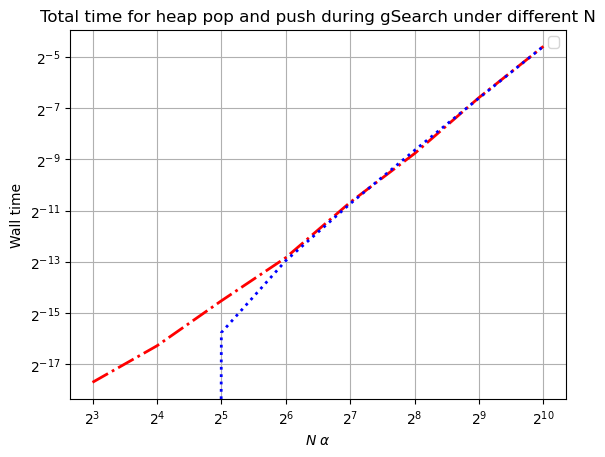

PyObject Text(0.5, 1.0, 'Total time for heap pop and push during gSearch under different N')

In [77]:
figure(1)
loglog(nlist, tk1, color="red", linewidth=2.0, linestyle="-.", base = 2)
# plot(nlist, tk1, color="red", linewidth=2.0, linestyle="-.")


fst = 1
lst = length(nlist)



# ploy1 = fit(nlist[fst:lst].*log2.(nlist[fst:lst]), tk1[fst:lst], 1)
# b1, a1 = ploy1.coeffs[1], ploy1.coeffs[2]
# println((a1, b1))

ploy2 = fit(nlist[fst:lst], tk1[fst:lst], 2)
println(ploy2)
c, b, a = ploy2.coeffs[1], ploy2.coeffs[2], ploy2.coeffs[3]

println((c, b, a ))





# loglog(nlist, a1.*nlist.*log2.(nlist).+b1, color="blue", linewidth=2.0, linestyle="dotted", base = 2)

# loglog(nlist, a1.*log2.(nlist).+b1, color="blue", linewidth=2.0, linestyle="dotted", base = 2)

loglog(nlist, a.*nlist.^2 .+ b.*nlist .+ c, color="blue", linewidth=2.0, linestyle="dotted", base = 2)
# plot(nlist, a.*nlist.^2 .+ b.*nlist .+ c, color="blue", linewidth=2.0, linestyle="dotted")

xlabel(L"$N$ $\alpha$")
ylabel("Wall time")
grid()
legend()
title("Total time for heap pop and push during gSearch under different N")


